In [70]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Example 00: Two-link

Integrating two-link, using variational integrator based on Discrete Euler-Lagrange


# Problem definition


In [71]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from varitop.problem import VaritopProblem
from varitop.misc import euler_quadrature
import casadi as cs
import numpy as np

In [72]:
nodes = 50
problem = VaritopProblem()
problem.set_nodes(nodes)
problem.set_quadrature(euler_quadrature)

In [73]:
qs = problem.create_state("q", 6)
vs = problem.create_velocity("v", 6)

In [74]:
q, v = qs[0], vs[0]
q, v

(SX([q_0, q_1, q_2, q_3, q_4, q_5]), SX([v_0, v_1, v_2, v_3, v_4, v_5]))

Here we are assuming all masses and lengths are equal to 1 for simplicity


In [75]:
kinetic_energy = cs.Function("E", [v], [0.5 * v.T @ v])
potential_energy = cs.Function("U", [q], [9.81 * (q[1] + q[3] + q[5])])
total_energy = cs.Function("H", [q, v], [kinetic_energy(v) + potential_energy(q)])
lagrangian = cs.Function("L", [q, v], [kinetic_energy(v) - potential_energy(q)])

In [76]:
phi0 = cs.Function("phi0", [q], [q[1]])
phi3 = cs.Function("phi3", [q], [q[0]])
phi1 = cs.Function("phi1", [q], [(q[0] - q[2]) ** 2 + (q[1] - q[3]) ** 2 - 1])
phi2 = cs.Function("phi2", [q], [(q[2] - q[4]) ** 2 + (q[3] - q[5]) ** 2 - 1])

In [77]:
problem.add_constraint("=", phi0)
problem.add_constraint("=", phi1)
problem.add_constraint("=", phi2)
problem.add_constraint("=", phi3)

In [78]:
q_0 = np.array(
    [
        0,
        0,
        0,
        1,
        -1 * np.sin(np.pi / 3),
        1 * np.cos(np.pi / 3) + 1,
    ]
)

In [79]:
problem.set_continuous_lagrangian(lagrangian)
discrete_lagrangian = problem.get_discrete_lagrangian()

# Discrete Euler-Lagrange


In [80]:
del_constraint = problem.get_del_residual()
del_constraint

Function(DEL:(q-1[10],q[6],q+1[6],dt)->(DEL_residual[10]) SXFunction)

In [81]:
rf = cs.rootfinder("rf", "newton", del_constraint)

In [82]:
steps = 10000
t0 = 0
tf = 25
tspan = [t0, tf]
ts = np.linspace(t0, tf, steps)
dt = (tspan[1] - tspan[0]) / steps

q = np.zeros((steps, 6))
lambdas = np.zeros((steps, 4))
phis = np.zeros((steps, 4))
K = np.zeros(steps)
U = np.zeros(steps)
E = np.zeros(steps)

U[0] = potential_energy(q_0)
E[0] = total_energy(q_0, np.zeros(6))
q[0, :] = q_0
q[1, :] = q_0

for i in tqdm(range(2, steps)):
    next_step = rf([*q[i - 1, :], *lambdas[i - 1, :]], q[i - 1, :], q[i - 2, :], dt)
    next_step = np.array(next_step)
    q[i, :] = next_step[:6].ravel()
    lambdas[i, :] = next_step[6:].ravel()
    phis[i, :] = np.array([phi(q[i, :]) for phi in [phi0, phi1, phi2, phi3]]).ravel()
    K[i] = kinetic_energy((q[i, :] - q[i - 1, :]) / dt)
    U[i] = potential_energy(q[i, :])
    E[i] = total_energy(q[i, :], (q[i, :] - q[i - 1, :]) / dt)

 37%|███▋      | 3708/9998 [00:02<00:04, 1466.40it/s]

100%|██████████| 9998/9998 [00:06<00:00, 1500.34it/s]


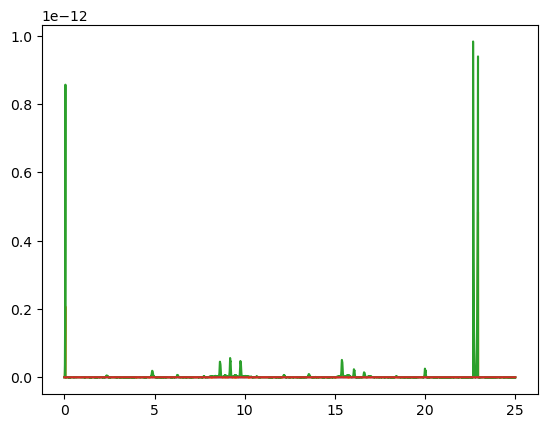

In [83]:
plt.plot(ts, phis)
plt.show()

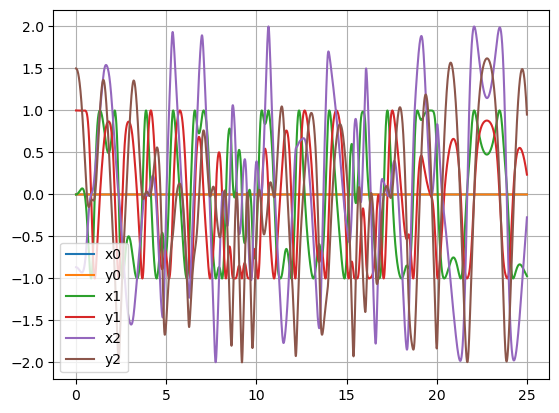

In [84]:
# plot how coordinates change over time
plt.plot(ts, q[:, 0], label="x0")
plt.plot(ts, q[:, 1], label="y0")
plt.plot(ts, q[:, 2], label="x1")
plt.plot(ts, q[:, 3], label="y1")
plt.plot(ts, q[:, 4], label="x2")
plt.plot(ts, q[:, 5], label="y2")
plt.legend()
plt.grid()

plt.show()

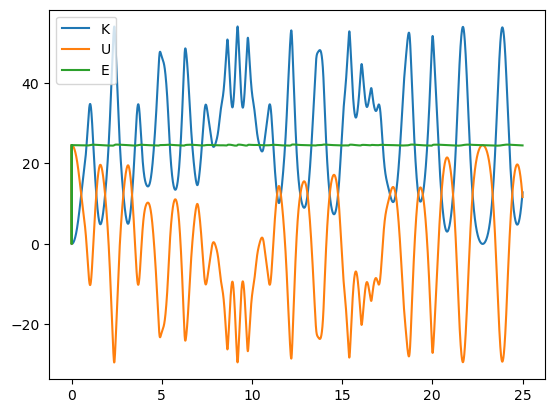

In [85]:
plt.plot(ts, K, label="K")
plt.plot(ts, U, label="U")
plt.plot(ts, E, label="E")
plt.legend()
plt.show()

# Discrete Euler-Lagrange in Momentum Form


In [86]:
momentum = cs.Function("p", [v], [cs.jacobian(kinetic_energy(v), v)])

In [87]:
p = problem.create_momentum("p", 6)

In [88]:
p_residual, p_next = problem.get_delm_residual()

In [89]:
rf = cs.rootfinder("rf", "fast_newton", p_residual)
display(rf)

Function(rf:([q+1, lambdas][10],p[6],q[6],dt)->(P_residual[10]) FastNewton)

In [90]:
steps = 10000
t0 = 0
tf = 25
tspan = [t0, tf]
ts = np.linspace(t0, tf, steps)
dt = (tspan[1] - tspan[0]) / steps

q_sol = np.zeros((steps, 6))
p_sol = np.zeros((steps, 6))
lambdas = np.zeros((steps, 4))
phis = np.zeros((steps, 4))
K = np.zeros(steps)
U = np.zeros(steps)
E = np.zeros(steps)

q_sol[0, :] = q_0
p_sol[0, :] = momentum(np.zeros(6)).full().ravel()
K[0] = kinetic_energy(p_sol[0, :])
U[0] = potential_energy(q_sol[0, :])
E[0] = total_energy(q_sol[0, :], p_sol[0, :])

for i in tqdm(range(1, steps)):
    next_step = rf(
        [*q_sol[i - 1, :], *lambdas[i - 1, :]], p_sol[i - 1, :], q_sol[i - 1, :], dt
    )
    next_step = np.array(next_step)
    q_sol[i, :] = next_step[:6].ravel()
    p_sol[i, :] = p_next(q_sol[i - 1, :], q_sol[i, :], dt).full().ravel()

    lambdas[i, :] = next_step[6:].ravel()
    phis[i, :] = np.array(
        [phi(q_sol[i, :]) for phi in [phi0, phi1, phi2, phi3]]
    ).ravel()
    K[i] = kinetic_energy(p_sol[i, :])
    U[i] = potential_energy(q_sol[i, :])
    E[i] = total_energy(q_sol[i, :], p_sol[i, :])

100%|██████████| 9999/9999 [00:06<00:00, 1497.83it/s]


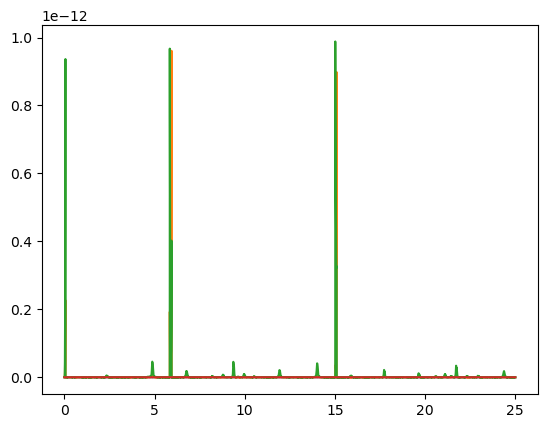

In [91]:
plt.plot(ts, phis)
plt.show()

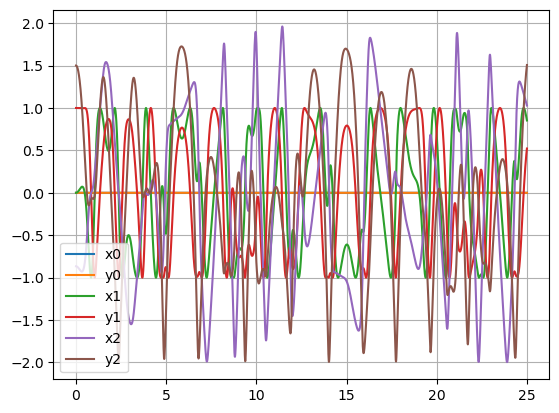

In [92]:
# plot how coordinates change over time
plt.plot(ts, q_sol[:, 0], label="x0")
plt.plot(ts, q_sol[:, 1], label="y0")
plt.plot(ts, q_sol[:, 2], label="x1")
plt.plot(ts, q_sol[:, 3], label="y1")
plt.plot(ts, q_sol[:, 4], label="x2")
plt.plot(ts, q_sol[:, 5], label="y2")
plt.legend()
plt.grid()

plt.show()

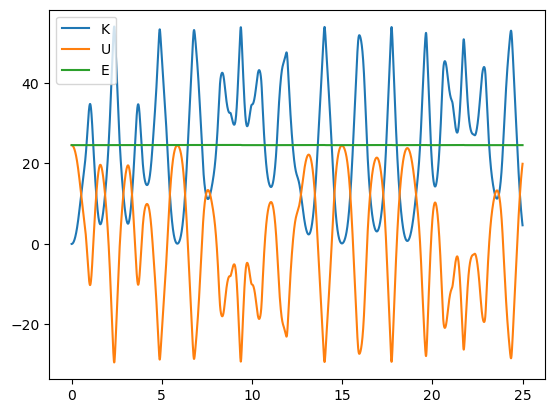

In [93]:
plt.plot(ts, K, label="K")
plt.plot(ts, U, label="U")
plt.plot(ts, E, label="E")
plt.legend()
plt.show()